Loading and preprocessing data...

Initial Data Statistics:
------------------------------
Dataset shape: (20640, 8)

Missing values check:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

Outlier Bounds for Target Variable:
Lower bound: -0.98
Upper bound: 4.82
Number of outliers: 1071
Percentage of outliers: 5.19%


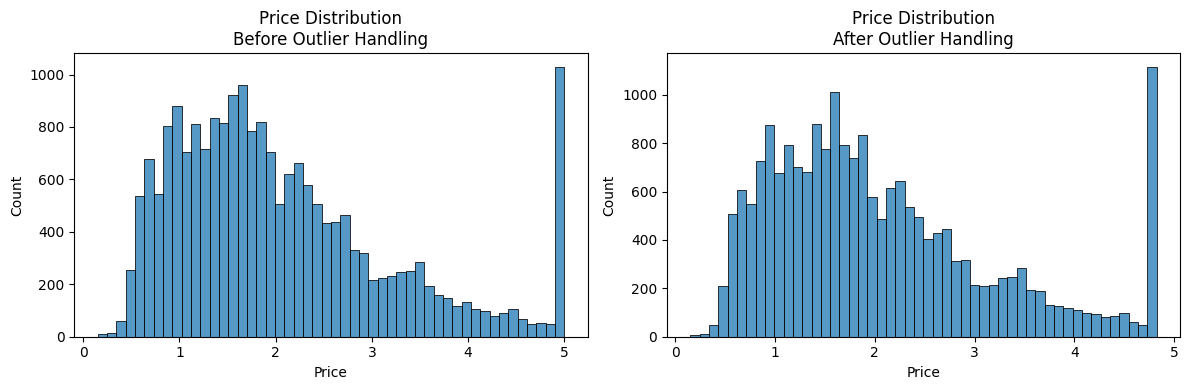


Splitting data...

Dataset Splits:
Training set: 12384 samples
Validation set: 4128 samples
Test set: 4128 samples

Scaling features...

Training model...

Model Performance Metrics:
------------------------------
Training RMSE: 0.7042
Training R²: 0.6109
Validation RMSE: 0.7153
Validation R²: 0.6125
Test RMSE: 0.7358
Test R²: 0.5718

Model Generalization Gaps:
------------------------------
Train-Val RMSE Gap: 0.0111
Train-Test RMSE Gap: 0.0316
Train-Val R² Gap: 0.0015
Train-Test R² Gap: 0.0391

Plotting predictions...


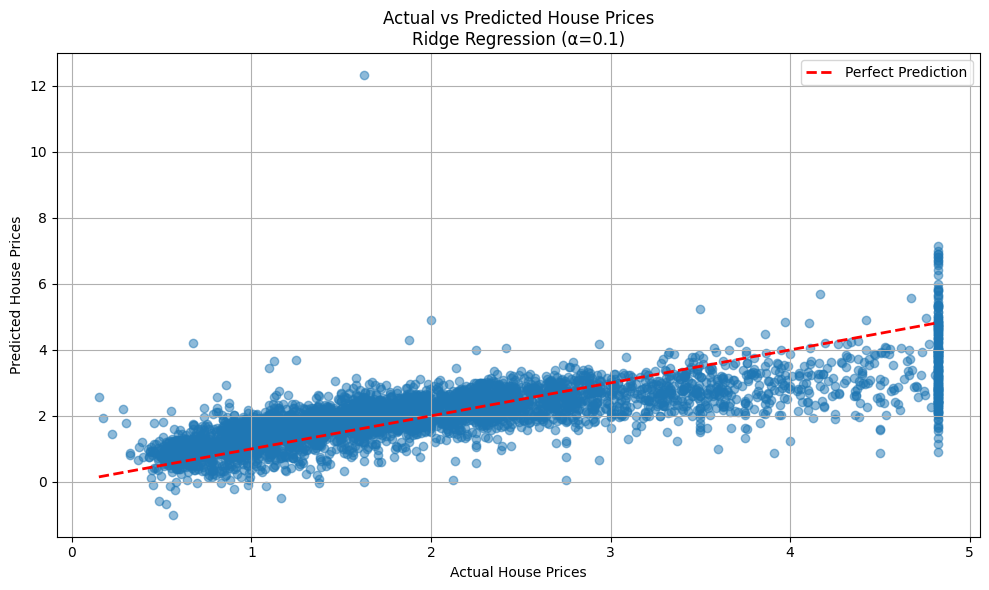


Feature Importance:
------------------------------
      Feature  Coefficient
6    Latitude    -0.892971
7   Longitude    -0.866018
0      MedInc     0.834681
3   AveBedrms     0.298747
2    AveRooms    -0.265325
1    HouseAge     0.114544
5    AveOccup    -0.025634
4  Population    -0.008491


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

def load_and_preprocess_data():
    """Load and preprocess the California housing dataset."""
    # Load the dataset
    california_housing = fetch_california_housing(as_frame=True)
    X = california_housing.data
    y = california_housing.target

    # Print initial statistics
    print("\nInitial Data Statistics:")
    print("-" * 30)
    print("Dataset shape:", X.shape)
    print("\nMissing values check:")
    print(X.isnull().sum())

    # Handle missing values using median imputation
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(
        imputer.fit_transform(X),
        columns=X.columns,
        index=X.index
    )

    # Handle outliers in target variable using IQR method
    Q1 = np.percentile(y, 25)
    Q3 = np.percentile(y, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print("\nOutlier Bounds for Target Variable:")
    print(f"Lower bound: {lower_bound:.2f}")
    print(f"Upper bound: {upper_bound:.2f}")
    print(f"Number of outliers: {sum((y < lower_bound) | (y > upper_bound))}")
    print(f"Percentage of outliers: {sum((y < lower_bound) | (y > upper_bound))/len(y)*100:.2f}%")

    # Clip outliers to bounds
    y_clean = np.clip(y, lower_bound, upper_bound)

    # Plot target variable distribution before and after outlier handling
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(y, bins=50, ax=ax1)
    ax1.set_title('Price Distribution\nBefore Outlier Handling')
    ax1.set_xlabel('Price')

    sns.histplot(y_clean, bins=50, ax=ax2)
    ax2.set_title('Price Distribution\nAfter Outlier Handling')
    ax2.set_xlabel('Price')

    plt.tight_layout()
    plt.show()

    return X_imputed, y_clean

def split_data(X, y, test_size=0.2, val_size=0.2):
    """Split data into train, validation and test sets."""
    # First split into training + validation and test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )

    # Then split training into training and validation
    val_size_adjusted = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size_adjusted, random_state=42
    )

    print("\nDataset Splits:")
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_val, X_test, y_train, y_val, y_test

def scale_features(X_train, X_val, X_test):
    """Scale features using StandardScaler."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

def evaluate_model(y_true, y_pred, dataset_name):
    """Calculate and print evaluation metrics."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_name} RMSE: {rmse:.4f}")
    print(f"{dataset_name} R²: {r2:.4f}")
    return rmse, r2

def plot_predictions(y_test, y_pred):
    """Plot actual vs predicted values."""
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual House Prices')
    plt.ylabel('Predicted House Prices')
    plt.title('Actual vs Predicted House Prices\nRidge Regression (α=0.1)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X, y = load_and_preprocess_data()

    # Split data
    print("\nSplitting data...")
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    # Scale features
    print("\nScaling features...")
    X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_features(
        X_train, X_val, X_test
    )

    # Train model
    print("\nTraining model...")
    model = Ridge(alpha=0.1, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_train_pred = model.predict(X_train_scaled)
    y_val_pred = model.predict(X_val_scaled)
    y_test_pred = model.predict(X_test_scaled)

    # Evaluate model
    print("\nModel Performance Metrics:")
    print("-" * 30)
    train_rmse, train_r2 = evaluate_model(y_train, y_train_pred, "Training")
    val_rmse, val_r2 = evaluate_model(y_val, y_val_pred, "Validation")
    test_rmse, test_r2 = evaluate_model(y_test, y_test_pred, "Test")

    # Calculate and print gaps
    print("\nModel Generalization Gaps:")
    print("-" * 30)
    print(f"Train-Val RMSE Gap: {abs(train_rmse - val_rmse):.4f}")
    print(f"Train-Test RMSE Gap: {abs(train_rmse - test_rmse):.4f}")
    print(f"Train-Val R² Gap: {abs(train_r2 - val_r2):.4f}")
    print(f"Train-Test R² Gap: {abs(train_r2 - test_r2):.4f}")

    # Plot predictions
    print("\nPlotting predictions...")
    plot_predictions(y_test, y_test_pred)

    # Print feature importance
    print("\nFeature Importance:")
    print("-" * 30)
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    })
    print(feature_importance.sort_values(by='Coefficient', key=abs, ascending=False))

if __name__ == "__main__":
    main()